MPDATA import

In [1]:
from MPyDATA import ScalarField, VectorField, PeriodicBoundaryCondition

Auxiliary functions

In [2]:
from numpy import gradient
import numpy as np
import matplotlib.pyplot as plt


#extrapolation to value^{t+0.5}
def extrapolate_in_time(u_old, u_new):
    u_mid = (3. * u_new - u_old) * .5
    return u_mid

def grad(mass, dy=1., dx=1.):
    grad_y = np.array(gradient(mass, axis=0)) / dy
    grad_x = np.array(gradient(mass, axis=1)) / dx
    return  grad_y, grad_x

def interpolate_in_space_axis_x(uh, h):
    u = np.zeros((ny, nx + 1))
    result = np.array(uh)
    
    zero_h = h==0.
    non_zero_h = h!=0.
    result[non_zero_h] /= h[non_zero_h]
    result[zero_h] = 0.
    
    for i in range(ny):
        for j in range(1, nx):
            u[i][j] = (result[i][j-1] + result[i][j]) / 2.
    return u
            
def interpolate_in_space_axis_y(uh, h):
    u = np.zeros((ny + 1, nx))
    result = np.array(uh)
    
    zero_h = h==0
    non_zero_h = h!=0.
    result[non_zero_h] /= h[non_zero_h]
    result[zero_h] = 0.
    
    for j in range(nx):
        for i in range(1, ny):
            u[i][j] = (result[i-1][j] + result[i][j]) / 2.
    return u

coriolis_p = 2. * np.pi / 86164. # * sine(90)

Advectee and advector initialization

In [3]:
from MPyDATA.options import Options
options = Options(n_iters=2, infinite_gauge=True, flux_corrected_transport=True)

#initial state of liquid
h_initial = np.array([[0.,.1,0.],[.1,.2,.1],[0.,.1,0.]])

nx = h_initial.shape[1]
ny = h_initial.shape[0]


h_old = np.array(h_initial)
h_new = np.array(h_initial)

uh_new_x = np.zeros((ny, nx))
uh_old_x = np.zeros((ny, nx))
uh_new_y = np.zeros((ny, nx))
uh_old_y = np.zeros((ny, nx))

u_initial_x = np.zeros((ny, nx + 1))
u_initial_y = np.zeros((ny + 1, nx))

u_old =  np.array(u_initial_y), np.array(u_initial_x)
u_new =  np.array(u_initial_y), np.array(u_initial_x)

rhs_old_x = np.array(h_initial)
rhs_old_y = np.array(h_initial)
rhs_new_x = np.array(h_initial)
rhs_new_y = np.array(h_initial)

halo = options.n_halo

advectee = ScalarField(
    data = h_new,
    halo=halo, 
    boundary_conditions=(PeriodicBoundaryCondition(), PeriodicBoundaryCondition())
)

advector = VectorField(
    data = (u_initial_y, u_initial_x),
    halo=halo,
    boundary_conditions=(PeriodicBoundaryCondition(), PeriodicBoundaryCondition())   
)

print('h_new', h_new,'\n')
print('u_initial_x', u_initial_y,'\n')
print('grad_x', grad(h_new)[0],'\n')

h_new [[0.  0.1 0. ]
 [0.1 0.2 0.1]
 [0.  0.1 0. ]] 

u_initial_x [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]] 

grad_x [[ 0.1  0.1  0.1]
 [ 0.   0.   0. ]
 [-0.1 -0.1 -0.1]] 



Stepper setup

In [4]:
from MPyDATA.stepper import Stepper
stepper = Stepper(options=options, grid=(ny, nx))

from MPyDATA.solver import Solver
solver = Solver(stepper=stepper, advectee=advectee, advector=advector)

Initial state

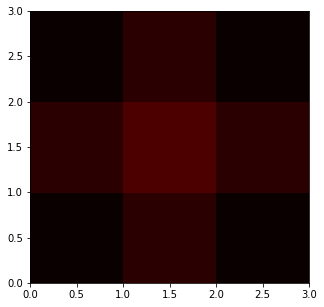

In [5]:
# plt.imshow(h_new, cmap='hot', interpolation='nearest')
# plt.pcolor(h_new, cmap=plt.cm.seismic, vmin=0, vmax=2)
image_width = image_height = 5
plt.figure(figsize=(image_width, image_height))
plt.pcolor(h_new, cmap='hot', vmin=0, vmax=2)
# plt.colorbar()
plt.show()

MPDATA function

In [6]:
def MPDATA(advector, advectee):
    solver.curr.get()[:] = advectee
    solver.GC_phys.get_component(0)[:] = advector[0]
    solver.GC_phys.get_component(1)[:] = advector[1]
    solver.advance(nt=1)
    return solver.curr.get() 

Main loop

/home/white/study/cm/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/white/study/cm/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app
/home/white/study/cm/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/white/study/cm/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


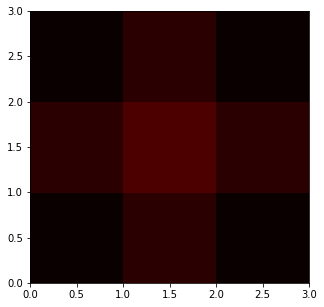

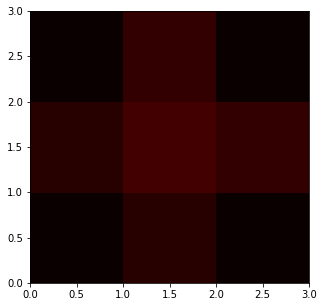

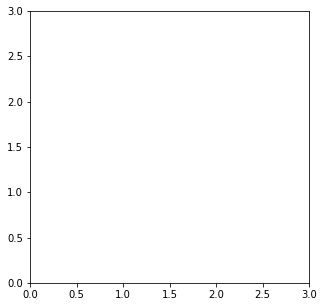

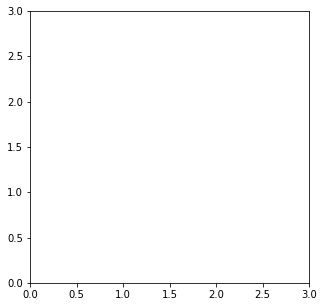

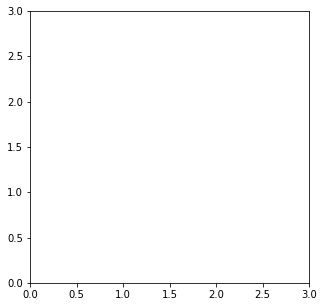

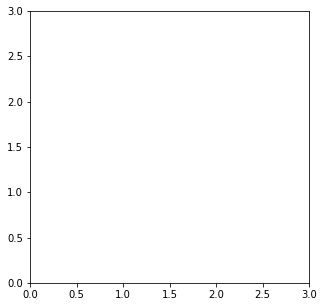

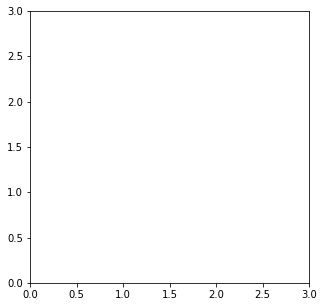

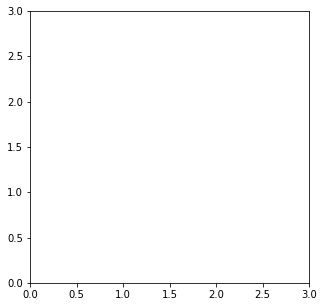

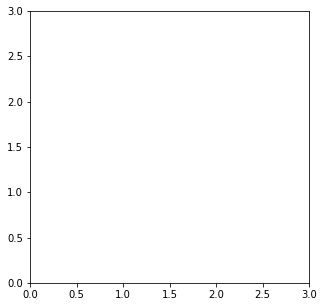

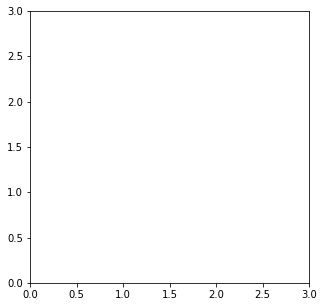

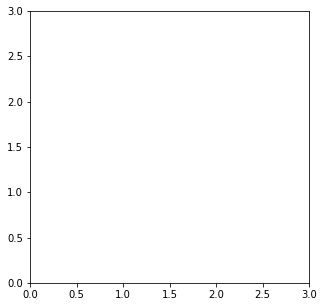

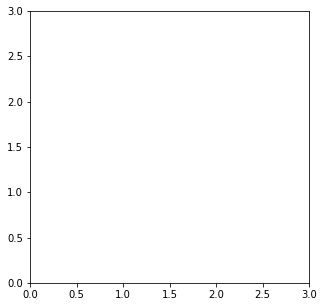

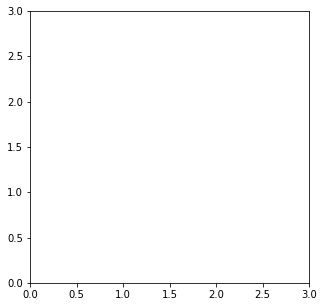

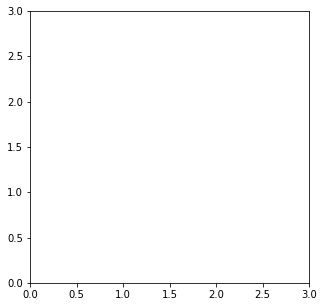

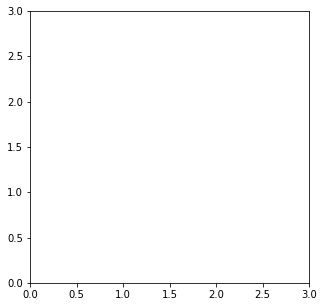

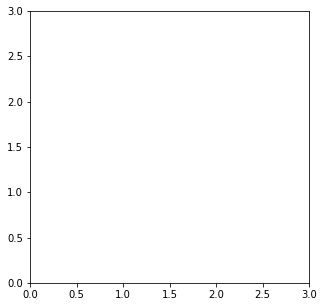

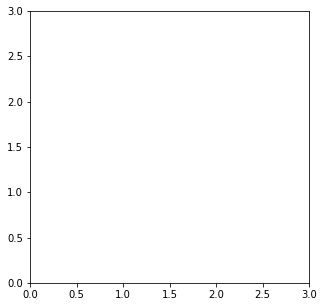

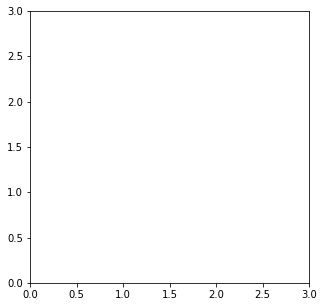

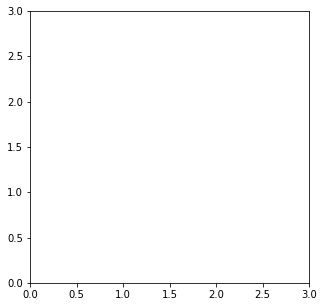

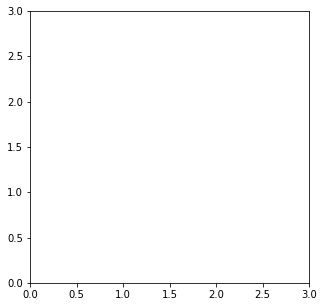

In [7]:
g = 9.8 # m/s^2
dx = 1.
dy = 1.
dt = 0.1

for i in range(20):
    u_mid_x = extrapolate_in_time(interpolate_in_space_axis_x(uh_new_x, h_new), interpolate_in_space_axis_x(uh_old_x, h_old))
    u_mid_y = extrapolate_in_time(interpolate_in_space_axis_y(uh_new_y, h_new), interpolate_in_space_axis_y(uh_old_y, h_old))
    u_mid = (u_mid_y, u_mid_x)

    #RHS = 0, mass conservation
    h_new[:] = MPDATA(u_mid, h_old)
    
    grad_y, grad_x = grad(h_new, dx=dx, dy=dy)
    rhs_new_x = -g * h_new * grad_x + (coriolis_p * uh_new_y) + ((1./h_new)*(grad_y - grad_x) * uh_new_y)
    rhs_new_y = -g * h_new * grad_y - (coriolis_p * uh_new_x) - ((1./h_new)*(grad_y - grad_x) * uh_new_x)

    #momentum conservation
    uh_new_x[:] = MPDATA(u_mid, uh_old_x + .5 * dt * rhs_old_x) + .5 * dt * rhs_new_x
    uh_new_y[:] = MPDATA(u_mid, uh_old_y + .5 * dt * rhs_old_y) + .5 * dt * rhs_new_y
    
    #plot figure
    plt.figure(figsize=(image_width,image_height))
    plt.pcolor(h_new, cmap='hot', vmin=0, vmax=2)
    plt.show()
   
    # replace variables
    h_old, h_new = h_new, h_old
    u_old, u_new = u_new, u_old
    
    rhs_old_x, rhs_new_x = rhs_new_x, rhs_old_x
    rhs_old_y, rhs_new_y = rhs_new_y, rhs_old_y
    
    uh_old_x, uh_new_x = uh_new_x, uh_old_x
    uh_old_y, uh_new_y = uh_new_y, uh_old_y

    #save array to a file
    np.save(str(i) + '.npy', h_new)